<a href="https://www.kaggle.com/code/trangnguyenkieu/vgg16?scriptVersionId=129426275" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import cv2
import imageio
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.models import Sequential
# from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import binary_accuracy
from tensorflow.keras.layers import Activation
import shutil
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.figure_factory as ff
from keras.applications.vgg16 import VGG16
from keras import layers
import tensorflow as tf
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [3]:
covid = pd.read_excel('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID.metadata.xlsx')
covid.head()

,FILE NAME,FORMAT,SIZE,URL
0,COVID-1,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
1,COVID-2,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
2,COVID-3,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
3,COVID-4,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
4,COVID-5,PNG,256*256,https://sirm.org/category/senza-categoria/covi...


In [4]:
normal = pd.read_excel('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal.metadata.xlsx')
normal.head()

,FILE NAME,FORMAT,SIZE,URL
0,NORMAL-1,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
1,NORMAL-2,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
2,NORMAL-3,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
3,NORMAL-4,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
4,NORMAL-5,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...


In [5]:
SAMPLE_SIZE = 3616

In [6]:
covid['label'] = 0
normal['label'] = 1

In [7]:
covid = covid[['FILE NAME', 'label']]
normal = normal[['FILE NAME', 'label']]

In [8]:
# sampling data for covid and normal cases
df_0 = covid.sample(SAMPLE_SIZE, random_state=26)
df_1 = normal.sample(SAMPLE_SIZE, random_state=26)

# concat dataframes
data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)

# check numbers of each label
data['label'].value_counts()

0    3616
1    3616
Name: label, dtype: int64

In [55]:
# shuffle data
data = shuffle(data)
data.head()

,FILE NAME,label
3011,COVID-22,0
3127,COVID-316,0
5348,NORMAL-9791,1
476,COVID-3407,0
487,COVID-2792,0


In [56]:
df_train, df_val = train_test_split(data, test_size=0.20, random_state=26, stratify=data['label'])
df_test, df_val = train_test_split(df_val, test_size=0.50, random_state=26, stratify=df_val['label'])

print(df_train.shape)
print(df_val.shape)
print(df_test)

(5785, 2)
(724, 2)
        FILE NAME  label
5049  NORMAL-3961      1
5412  NORMAL-8435      1
1817   COVID-2060      0
4249  NORMAL-8370      1
5995  NORMAL-4560      1
...           ...    ...
3602   COVID-1652      0
3260   COVID-2253      0
6740   NORMAL-348      1
3320     COVID-91      0
2287   COVID-1936      0

[723 rows x 2 columns]


In [13]:
# Create a new directory
base_dir = 'base_dir'
os.mkdir(base_dir)

# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)

In [14]:
test_dir = os.path.join(base_dir, 'test_dir')
os.mkdir(test_dir)

In [15]:
train_covid = os.path.join(train_dir, 'covid')
os.mkdir(train_covid)
train_normal = os.path.join(train_dir, 'normal')
os.mkdir(train_normal)

# create new folders inside val_dir
val_covid = os.path.join(val_dir, 'covid')
os.mkdir(val_covid)
val_normal = os.path.join(val_dir, 'normal')
os.mkdir(val_normal)

In [16]:
test_covid = os.path.join(test_dir, 'covid')
os.mkdir(test_covid)
test_normal = os.path.join(test_dir, 'normal')
os.mkdir(test_normal)

In [17]:
train_list = list(df_train['FILE NAME'])
val_list = list(df_val['FILE NAME'])
test_list = list(df_test['FILE NAME'])

In [57]:
print(test_list)

['NORMAL-8811', 'NORMAL-4768', 'COVID-1483', 'NORMAL-5243', 'NORMAL-646', 'NORMAL-2718', 'COVID-2184', 'COVID-1582', 'NORMAL-5564', 'NORMAL-2371', 'COVID-2803', 'NORMAL-1573', 'COVID-2243', 'NORMAL-2231', 'NORMAL-2789', 'NORMAL-2459', 'COVID-2385', 'COVID-2413', 'NORMAL-9327', 'NORMAL-495', 'NORMAL-8391', 'NORMAL-3485', 'COVID-2987', 'NORMAL-251', 'COVID-2395', 'COVID-1370', 'COVID-1077', 'NORMAL-3610', 'NORMAL-1635', 'COVID-779', 'COVID-1328', 'NORMAL-9234', 'COVID-2706', 'COVID-132', 'COVID-2098', 'COVID-2752', 'COVID-972', 'COVID-2344', 'COVID-438', 'NORMAL-7197', 'NORMAL-1849', 'COVID-131', 'COVID-265', 'NORMAL-6729', 'NORMAL-6939', 'COVID-586', 'COVID-3046', 'COVID-3557', 'COVID-2983', 'NORMAL-3803', 'NORMAL-372', 'NORMAL-5151', 'COVID-486', 'COVID-1193', 'COVID-991', 'COVID-929', 'COVID-2783', 'NORMAL-8881', 'COVID-857', 'NORMAL-3506', 'COVID-1331', 'COVID-152', 'COVID-319', 'NORMAL-6579', 'COVID-3375', 'NORMAL-1914', 'COVID-2899', 'COVID-2216', 'NORMAL-6910', 'NORMAL-1682', 'COV

In [18]:
for image in train_list:
    
    # add .png extension 
    filename = image + '.png'
    # get the label for a certain image
    target = int(data.loc[data['FILE NAME'] == image, ['label']].values)
    
    # match the target with the folder's name and source path of the image
    if target == 0:
        label = 'covid'
        src = os.path.join('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images', filename)
        
    if target == 1:
        label = 'normal'
        # As 'FILE NAME's in .xlsx file begins with 'NORMAL' but real file names begin with 'Normal'
        filename = filename.capitalize()
        src = os.path.join('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images', filename)
  
    # destination path to image
    dst = os.path.join(train_dir, label, filename)
    
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
# Copy images to val_dir folder
for image in val_list:
    
    # add .png extension 
    filename = image + '.png'
    # get the label for a certain image
    target = int(data.loc[data['FILE NAME'] == image, ['label']].values)
    
    # match the target with the folder's name and source path of the image
    if target == 0:
        label = 'covid'
        src = os.path.join('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images', filename)
        
    if target == 1:
        label = 'normal'
        filename = filename.capitalize()
        src = os.path.join('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images', filename)
    # destination path to image
    dst = os.path.join(val_dir, label, filename)
    
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

In [19]:
for image in test_list:
    
    # add .png extension 
    filename = image + '.png'
    # get the label for a certain image
    target = int(data.loc[data['FILE NAME'] == image, ['label']].values)
    
    # match the target with the folder's name and source path of the image
    if target == 0:
        label = 'covid'
        src = os.path.join('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images', filename)
        
    if target == 1:
        label = 'normal'
        filename = filename.capitalize()
        src = os.path.join('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images', filename)
    # destination path to image
    dst = os.path.join(test_dir, label, filename)
    
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

In [19]:
print(len(os.listdir('base_dir/train_dir/covid')))
print(len(os.listdir('base_dir/train_dir/normal')))

2893
2892


In [20]:
train_path = "base_dir/train_dir"
val_path = "base_dir/val_dir"
test_path = "base_dir/test_dir"

In [65]:
datagen = ImageDataGenerator(rescale=1.0/255)
train_datagen = ImageDataGenerator(rescale=1./255,
        rotation_range=0.2,
        shear_range=0.2,
        horizontal_flip=True)
IMAGE_HEIGHT = 256
IMAGE_WIDTH= 256
train_gen = train_datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=32,class_mode = 'binary')

val_gen = datagen.flow_from_directory(val_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=32,class_mode = 'binary')

test_gen = datagen.flow_from_directory(test_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=32,class_mode = 'binary')
train_gen.shuffle = True

# Tiến hành shuffle
train_gen.on_epoch_end()
val_gen.shuffle = True

# Tiến hành shuffle
val_gen.on_epoch_end()
test_gen.shuffle = True

# Tiến hành shuffle
test_gen.on_epoch_end()

Found 5785 images belonging to 2 classes.
Found 724 images belonging to 2 classes.
Found 723 images belonging to 2 classes.


In [67]:
print(test_gen.classes)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [68]:
print(train_gen[0][0].shape)

(32, 256, 256, 3)


In [62]:
test_gen

In [70]:
base_model = VGG16(weights='/kaggle/input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(256,256, 3))

# Đóng băng các tầng của mô hình VGG16
for layer in base_model.layers:
    layer.trainable = False

# Xây dựng mô hình phân loại mới
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
model.add(Dense(512))
model.add(Activation("relu"))
# model.add(Dense(256))
# model.add(Activation("relu"))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation("sigmoid"))
# Summary model 
model.summary()
# model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_6 (Dense)             (None, 1024)              33555456  
                                                                 
 activation_6 (Activation)   (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 512)               524800    
                                                                 
 activation_7 (Activation)   (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                

In [71]:
learning_rate = 0.00001  # Tốc độ học ban đầu
decay_steps = 10          # Số epoch để áp dụng decay
decay_rate = 1            # Tỷ lệ giảm learning rate

# Khởi tạo learning rate scheduler
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(learning_rate, decay_steps, decay_rate)
optimizer1 = tf.keras.optimizers.Adam(learning_rate = lr_scheduler)
model.compile(optimizer = optimizer1, loss = 'binary_crossentropy',metrics =['accuracy'])

history = model.fit(train_gen,
    steps_per_epoch=train_gen.n // train_gen.batch_size,
    epochs=20,
    validation_data=val_gen,
    validation_steps=val_gen.n // val_gen.batch_size)

Epoch 1/20
180/180 [==============================] - 93s 506ms/step - loss: 0.3919 - accuracy: 0.8359 - val_loss: 0.2969 - val_accuracy: 0.8977
Epoch 2/20
180/180 [==============================] - 89s 491ms/step - loss: 0.2433 - accuracy: 0.9074 - val_loss: 0.2170 - val_accuracy: 0.9062
Epoch 3/20
180/180 [==============================] - 91s 504ms/step - loss: 0.1836 - accuracy: 0.9359 - val_loss: 0.1729 - val_accuracy: 0.9446
Epoch 4/20
180/180 [==============================] - 89s 495ms/step - loss: 0.1471 - accuracy: 0.9522 - val_loss: 0.1437 - val_accuracy: 0.9560
Epoch 5/20
180/180 [==============================] - 88s 489ms/step - loss: 0.1216 - accuracy: 0.9635 - val_loss: 0.1257 - val_accuracy: 0.9616
Epoch 6/20
180/180 [==============================] - 90s 498ms/step - loss: 0.1041 - accuracy: 0.9677 - val_loss: 0.1203 - val_accuracy: 0.9574
Epoch 7/20
180/180 [==============================] - 91s 508ms/step - loss: 0.0928 - accuracy: 0.9706 - val_loss: 0.1052 - val_ac

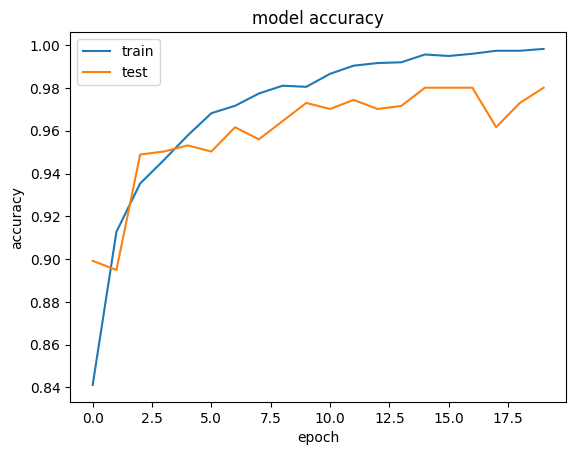

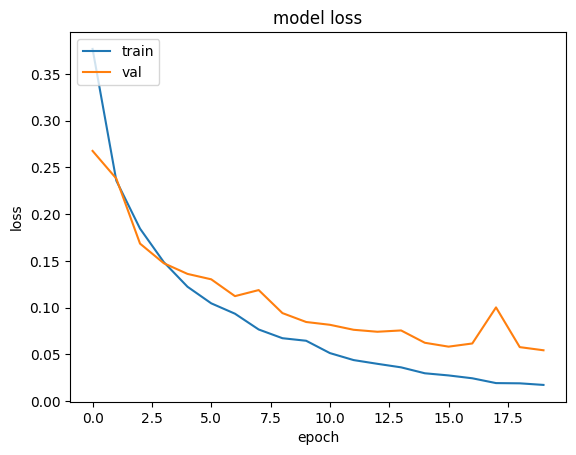

In [25]:
from matplotlib import pyplot  as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc ='upper left')
plt.show()
#summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'],loc ='upper left')
plt.show()

In [72]:
model.evaluate(test_gen)

23/23 [==============================] - 2s 103ms/step - loss: 0.0658 - accuracy: 0.9751


[0.06583255529403687, 0.9751037359237671]

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

23/23 [==============================] - 2s 101ms/step


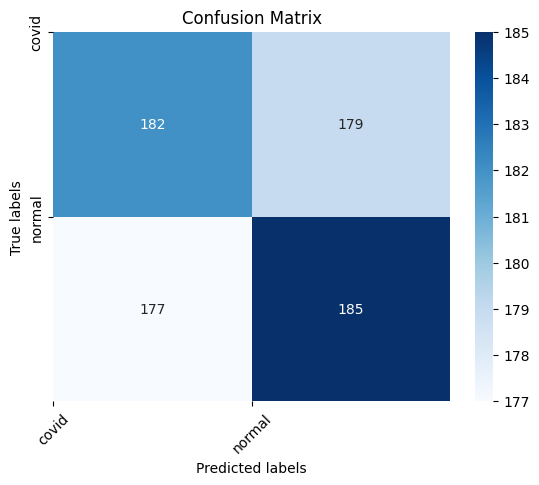

In [75]:
Y_pred = model.predict(test_gen)
def predict(y_hat):
    y_hat[y_hat >= 0.5] =1
    y_hat[y_hat<0.5] =0
    return y_hat
y_pred = predict(Y_pred)

# Tính confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Tạo heatmap từ confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Cấu hình labels trục x và trục y
class_names = test_gen.class_indices
class_labels = list(class_names.keys())
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

# Hiển thị confusion matrix
plt.show()

In [78]:
from sklearn.metrics import confusion_matrix, classification_report
labels = ['Covid', 'Normal']
report = classification_report(test_gen.classes, y_pred, target_names=labels)
print(report)

              precision    recall  f1-score   support

       Covid       0.51      0.50      0.51       361
      Normal       0.51      0.51      0.51       362

    accuracy                           0.51       723
   macro avg       0.51      0.51      0.51       723
weighted avg       0.51      0.51      0.51       723

